# Metagenomic Classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *
from Bio import Seq
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import FeatureLocation, CompoundLocation
import networkx as nx

In [3]:
sys.path.append("../../..")
from utils import *

In [4]:
path = Path('F:/genome/bacterial genomes/')

# Amplicon Data

In [5]:
fname = '16S-trimmed.fa'
fasta = SeqIO.parse(path/fname, 'fasta')
fs = [i for i in fasta]

In [6]:
len(fs)

28000

In [7]:
seqs = []
names = []

for sequence in fs:
    seqs.append(sequence.seq.__str__())
    
    name = sequence.description.split('description')[1][1:].strip('"')
    
    names.append(name)

In [8]:
len(names)

28000

In [9]:
len(set(names))

96

In [10]:
df = pd.DataFrame(seqs, columns=['Sequence'])
df['Species'] = names

In [11]:
df_clean = df[df.Sequence.map(lambda x: set(x.upper()) == set('ATGC'))]
df_clean.shape

(27223, 2)

In [12]:
def partition_data(df):
    
    train_size = int(len(df)*0.93*.93)
    valid_size = int(len(df)*0.93) - train_size
    
    train_df = df.sample(train_size)
    test_val = df.drop(train_df.index)
    valid_df = test_val.sample(valid_size)
    test_df = test_val.drop(valid_df.index)
    train_df['set'] = 'train'
    valid_df['set'] = 'valid'
    test_df['set'] = 'test'
    
    return (train_df, valid_df, test_df)

In [13]:
train_df, valid_df, test_df = partition_data(df_clean)

In [14]:
train_df.shape, valid_df.shape, test_df.shape

((23545, 3), (1772, 3), (1906, 3))

In [15]:
data_df = pd.concat([train_df, valid_df, test_df])

In [16]:
data_df.to_csv(path/'s16_amplicon_sequences.csv', index=False)

# Amplicon LM

In [5]:
classification_df = pd.read_csv(path/'s16_amplicon_sequences.csv')

In [6]:
classification_df.head()

,Sequence,Species,set
0,TGGGGAATCTTAGACAATGGGCGCAAGCCTGATCTAGCCATGCCGC...,Alphaproteobacteria Rhodobacterales Rhodobacte...,train
1,TGGGGAATATTGGACAATGGGCGCAAGCCTGATCCAGCCATGCCGC...,Alphaproteobacteria Rhizobiales Hyphomicrobiac...,train
2,TGGGGAATATTGGACAATGGGCGAAAGCCTGATCCAGCAATGCCGC...,Alphaproteobacteria Sphingomonadales Sphingomo...,train
3,TGGGGAATCTTAGACAATGGGGGCAACCCTGATCTAGCGATGCCGC...,Alphaproteobacteria Rhodobacterales Rhodobacte...,train
4,TGGGGAATATTGGACAATGGGCGCAAGCCTGATCCAGCCATGCCGC...,Alphaproteobacteria Rhizobiales Xanthobacterac...,train


In [7]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

In [8]:
train_df.shape, valid_df.shape, test_df.shape

((23545, 3), (1772, 3), (1906, 3))

In [9]:
voc = np.load(path/'bact_vocab.npy')
model_vocab = GenomicVocab(voc)

In [10]:
tok = Tokenizer(GenomicTokenizer, n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])

In [11]:
data = GenomicTextLMDataBunch.from_df(path, train_df, valid_df, bs=850, tokenizer=tok, 
                              chunksize=10000, text_cols='Sequence', label_cols='Species', vocab=model_vocab)

In [14]:
config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.25, 
                          hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15, tie_weights=True, out_bias=True)
drop_mult = 1.2

In [15]:
learn = get_model_LM(data, drop_mult, config)

In [16]:
learn.load('b2');

In [17]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(1025, 400, padding_idx=0)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(1025, 400, padding_idx=0)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=1025, bias=True)
    (output_dp): RNNDropout()
  )
)

In [18]:
learn = learn.to_fp16(dynamic=True);

In [32]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


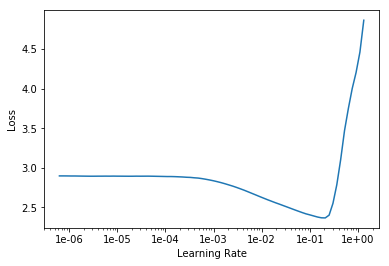

In [33]:
learn.recorder.plot()

# Training


In [ ]:
learn.fit_one_cycle(20, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time


In [38]:
learn.fit_one_cycle(10, 5e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,1.934241,1.698563,0.486731
2,1.619920,1.495913,0.558036
3,1.478185,1.420479,0.585899
4,1.398326,1.390347,0.598578
5,1.352802,1.375351,0.604084
6,1.322324,1.368947,0.606169
7,1.297703,1.366946,0.607922
8,1.276468,1.369305,0.608425
9,1.258326,1.374882,0.607133
10,1.248236,1.372086,0.608523


In [39]:
learn.save('s16_amp_LM')
learn.save_encoder('s16_amp_LM_enc')

# Classification

In [22]:
classification_df = pd.read_csv(path/'s16_amplicon_sequences.csv')

In [23]:
classification_df.head()

,Sequence,Species,set
0,TGGGGAATATTGGACAATGGGGGCAACCCTGATCCAGCCATGCCGC...,Alphaproteobacteria Rhizobiales Hyphomicrobiac...,train
1,TGGGGAATATTGGACAATGGGGGCAACCCTGATCCAGCCATGCCGC...,Gammaproteobacteria Oceanospirillales Oceanosp...,train
2,TGGGGAATATTGGACAATGGGGGCAACCCTGATCCAGCCATGCCGC...,Gammaproteobacteria Pseudomonadales Pseudomona...,train
3,TGGGGAATATTGCACAATGGGCGCAAGCCTGATGCAGCCAGACCGC...,Gammaproteobacteria Alteromonadales Psychromon...,train
4,TGGGGAATCTTAGACAATGGGGGAAACCCTGATCTAGCCATGCCGC...,Alphaproteobacteria Rhodobacterales Rhodobacte...,train


In [24]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

In [25]:
voc = np.load(path/'bact_vocab.npy')
model_vocab = GenomicVocab(voc)

In [26]:
tok = Tokenizer(GenomicTokenizer, n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, valid_df,
                                             tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Species', bs=400)

In [29]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4, 
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.5

In [30]:
learn = get_model_clas(data_clas, drop_mult, clas_config)

In [31]:
learn.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(1025, 400, padding_idx=0)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(1025, 400, padding_idx=0)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1150, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1150, 1150, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1150, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.

In [32]:
learn.load_encoder('s16_amp_LM_enc')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-02


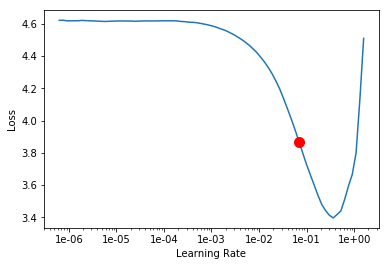

In [17]:
learn.lr_find()
learn.recorder.plot()

In [33]:
learn.fit_one_cycle(5, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,2.911551,1.494056,0.630361
2,1.475539,0.495826,0.792889
3,1.032347,0.419920,0.831828
4,0.823299,0.345005,0.864560
5,0.708074,0.325327,0.875282


In [34]:
learn.freeze_to(-2)
learn.fit_one_cycle(5, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.601157,0.291483,0.885440
2,0.485546,0.249758,0.898420
3,0.383020,0.225064,0.903499
4,0.314233,0.192666,0.906321
5,0.276384,0.192618,0.910271


In [35]:
learn.freeze_to(-3)
learn.fit_one_cycle(4, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.254704,0.201798,0.915350
2,0.244673,0.193892,0.907449
3,0.223569,0.185401,0.910835
4,0.205914,0.184677,0.911964


In [36]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.189874,0.186144,0.911964
2,0.191468,0.187243,0.912528
3,0.187987,0.183907,0.911400
4,0.184222,0.184279,0.911400
5,0.182020,0.181832,0.911964


In [37]:
learn.fit_one_cycle(5, slice(5e-4/(2.6**4),5e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.182210,0.181965,0.911400
2,0.180163,0.184350,0.913657
3,0.179487,0.181553,0.915350
4,0.173788,0.182956,0.915914
5,0.175287,0.182972,0.914221


In [38]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, test_df, tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Species', bs=400)
learn.data = data_clas

In [39]:
preds = learn.get_preds()

In [40]:
p = torch.argmax(preds[0], dim=1)

In [41]:
p

tensor([76, 23, 26,  ..., 40, 58, 70])

In [42]:
(p == preds[1]).float().mean()

tensor(0.9171)